# Parse Information from IAM Handwriting Dataset

### File format
The filenames are hyphen-separated. Test id - Writer id - Passage id - Sentence id.
* Linestroke file: a01-000u-01.xml (Test "a01" Writer "000u" Sentence "01")
* ASCII file: a01-000u.txt (Get the lines after CSR)

### References 
* http://www.fki.inf.unibe.ch/databases/iam-on-line-handwriting-database
* http://blog.otoro.net/2015/12/12/handwriting-generation-demo-in-tensorflow/
* https://github.com/greydanus/scribe
* https://github.com/greydanus/scribe/blob/master/sample.ipynb
* https://github.com/greydanus/scribe/blob/master/dataloader.ipynb
* https://distill.pub/2017/ctc/
* https://lirnli.wordpress.com/2017/09/24/notes-fake-handwriting-generation-with-pytorch/
* https://www.kaggle.com/tejasreddy/iam-handwriting-top50/kernels
* https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/kernels
* https://towardsdatascience.com/kaggle-tensorflow-speech-recognition-challenge-b46a3bca2501

In [1]:
import tensorflow as tf
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

stroke_dir = "data/lineStrokes"
ascii_dir = "data/ascii"
pickle_filename = "data/strokes_training_data.cpkl"

tf.enable_eager_execution()

### Read Stroke Directories
The most interesting files for us will be ascii and linestrokes

In [ ]:
# build the list of xml files
stroke_file_list = []
for dirName, subdirList, fileList in os.walk(stroke_dir):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
        #print('\t%s' % fname)
        if 'xml' in fname:
            stroke_file_list.append(dirName+"/"+fname)

print('Found:', len(stroke_file_list), ' directories to process')

### Process Stroke XML file
The XML format contains the tuple (x,y,time) of strokes, a stroke is basically when the pen touches the paper until it leaves the paper.
```XML
<Stroke colour="black" start_time="769.70" end_time="769.90">
      <Point x="1176" y="1237" time="769.70"/>
      <Point x="1175" y="1233" time="769.72"/>
      <Point x="1171" y="1229" time="769.74"/>
      <Point x="1169" y="1230" time="769.75"/>
      <Point x="1158" y="1230" time="769.76"/>
      <Point x="1139" y="1227" time="769.78"/>
      <Point x="1118" y="1228" time="769.80"/>
      <Point x="1092" y="1229" time="769.81"/>
      <Point x="1065" y="1233" time="769.82"/>
      <Point x="1041" y="1236" time="769.84"/>
      <Point x="1024" y="1239" time="769.86"/>
      <Point x="1015" y="1243" time="769.87"/>
      <Point x="1010" y="1239" time="769.88"/>
      <Point x="1014" y="1243" time="769.90"/>
    </Stroke>
```

In [ ]:
def getStrokes(filename):
    tree = ET.parse(filename)
    root = tree.getroot()

    result = []

    x_offset = 1e20
    y_offset = 1e20
    y_height = 0
    for i in range(1, 4):
        x_offset = min(x_offset, float(root[0][i].attrib['x']))
        y_offset = min(y_offset, float(root[0][i].attrib['y']))
        y_height = max(y_height, float(root[0][i].attrib['y']))
    y_height -= y_offset
    x_offset -= 100
    y_offset -= 100

    # Iterate on each stroke of the file
    for stroke in root[1].findall('Stroke'):
        points = []
        # Iterate on each point of the stroke
        for point in stroke.findall('Point'):
            points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
        result.append(points)
    return result

### Convert Stroke to Numpy Array
Format x,y,stroke where stroke is 1 when it's finished. The time is not needed because the strokes will appear in order.

In [ ]:
def convert_stroke_to_array(stroke):
    n_point = 0
    for i in range(len(stroke)):
        n_point += len(stroke[i])
    stroke_data = np.zeros((n_point, 3), dtype=np.int16)

    prev_x = 0
    prev_y = 0
    counter = 0

    for j in range(len(stroke)):
        for k in range(len(stroke[j])):
            stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
            stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
            prev_x = int(stroke[j][k][0])
            prev_y = int(stroke[j][k][1])
            stroke_data[counter, 2] = 0
            # Mark end of the stroke
            if (k == (len(stroke[j])-1)):
                stroke_data[counter, 2] = 1
            counter += 1
    return stroke_data

### Display Stroke

In [3]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    
    # Trick to avoid having the letters in the same place
    # Return the cumulative sum along a given axis. stroke_numpy[:,:-1]==>(X,Y)
    strokes[:,0:2] = np.cumsum(strokes[:,0:2], axis=0)
    
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

### Process ASCII File
We want to gather the lines bellow the CSR section. The ASCII files will have the same filename as the stroke xml files.

In [2]:
# function to read each individual xml file
def getAscii(filename, line_number):
    with open(filename, "r") as f:
        s = f.read()
    s = s[s.find("CSR"):]
    if len(s.split("\n")) > line_number+2:
        s = s.split("\n")[line_number+2]
        return s
    else:
        return ""

In [ ]:
file_num=1#12100
# Replace lineStrokes by ascii and change the .xml to .txt
print('Stroke filename:',stroke_file_list[file_num])
# Get the sentence id from the filename
sentence_num = int(stroke_file_list[file_num][-6:-4])-1
print('Sentence:', sentence_num)
# The ASCII filename is the same as the XML with some modifications
ascii_file = stroke_file_list[file_num].replace("lineStrokes","ascii")[:-7] + ".txt"
print('ASCII filename:',ascii_file)
stroke_raw = getStrokes(stroke_file_list[file_num])
stroke_numpy = convert_stroke_to_array(stroke_raw)
label = getAscii(ascii_file,sentence_num)
print('Label:', label)

# Preprocess strokes (Avoid outliers and scale)
stroke_numpy = np.minimum(stroke_numpy, 500)
stroke_numpy = np.maximum(stroke_numpy, -500)
stroke_numpy = np.array(stroke_numpy,dtype=np.float32)
stroke_numpy[:,0:2] /= 10

line_plot(stroke_numpy, label)

### Load Data from pickle

In [4]:
def load_preprocessed(data_file, tsteps=300, limit=500, scale_factor=10):
    f = open(data_file,"rb")
    [raw_stroke_data, raw_ascii_data] = pickle.load(f)
    f.close()

    # goes thru the list, and only keeps the text entries that have more than tsteps points
    stroke_data = []
    ascii_data = []
    counter = 0

    for i in range(len(raw_stroke_data)):
        data = raw_stroke_data[i]
        if len(data) > (tsteps+2):
            # removes large gaps from the data
            data = np.minimum(data, limit)
            data = np.maximum(data, -limit)
            data = np.array(data,dtype=np.float32)
            data[:,0:2] /= scale_factor

            stroke_data.append(data)
            ascii_data.append(raw_ascii_data[i])


    print ("Loaded dataset:")
    print ("   -> {} individual data points".format(len(stroke_data)))
    return stroke_data, ascii_data

Loaded dataset:
   -> 11600 individual data points


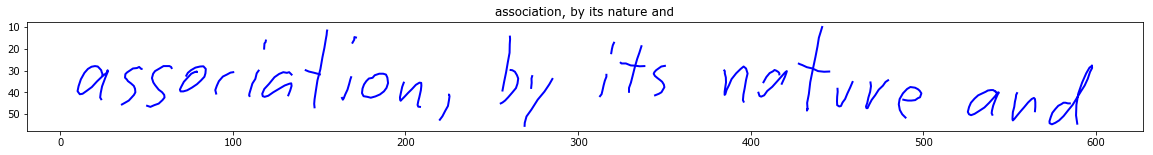

In [5]:
X,Y = load_preprocessed(pickle_filename)
X_np = np.asarray(X)
line_plot(X[0], Y[0])

### Convert Data to  Pandas Dataframe

In [6]:
df_handwriting = pd.DataFrame({'X':X_np,'Y':Y})
# Save dataframe to pickle
df_handwriting.to_pickle("data/strokes_training_data_df_processed.cpkl")

### Convert Pandas to Tensorflow Dataset

#### References
* https://www.tensorflow.org/guide/datasets
* https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168
* https://stackoverflow.com/questions/50641588/how-to-create-a-tensorflow-dataset-from-a-dataframe-with-vector-columns

In [ ]:
# (num_lines, num_strokes, 3)
def merge_strokes(X):
    stroke_array = np.zeros((len(X),3))
    for line in X:
        for stroke in line:
            #print(stroke.shape)
            pass
    return stroke_array

In [ ]:
merge_strokes(X_np)

In [ ]:
# The slices need feature names to work properly
training_dataset = tf.data.Dataset.from_tensor_slices((df_handwriting.X, df_handwriting.Y))